In [11]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import csv
from data_preparation  import preprocess_field_data, prepro_data_kl
from hsic import HSIC
import json
import matplotlib.pyplot as plt
from mcmc_integration_total import BayesCalibrationMCMC
from metamodels import VPCEMetamodel, KarhunenLoeveMetamodel, GpMetamodelInd
import numpy as np
import openturns as ot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
from plot import plot_tpd


BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/d8/t_gv.npy', allow_pickle=True)

csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'
input_dic = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [input_dic['chemistry']['cleaning'][i]['time']/24 for i in range(len(input_dic['chemistry']['cleaning']))]

plt.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def kl_div(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

# Methodology implementation

In [13]:
mc_hl = np.load(BASE_DIRECTORY + 'simulation_data/MC/d8/doe_hl.npy', allow_pickle=True)
mc_cl = np.load(BASE_DIRECTORY + 'simulation_data/MC/d8/doe_cl.npy', allow_pickle=True)

n_max = mc_hl.shape[0]
n_samp = 1000
input_dimension = 8


In [14]:
#Base metamodel
X, y, SCALER = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
GP = GpMetamodelInd(trend='Constant', kernel='AbsExp', input_dimension=(input_dimension-1))
full_metamodel = KarhunenLoeveMetamodel(metamodel=GP, input_dimension=input_dimension, simulation_time=SIMULATION_TIME)
full_metamodel.fit(X_train, y_train)

11 nan trajectories in output sample
Running Karhunen-Loeve decomposition
Explained variance for 2 modes is 0.999998157762496
Done fitting mode 1
Done fitting mode 2


WRN - (previous message repeated 3 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]


In [15]:
#Individual variable scalers
x, _ = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=False)
scalers = []
for i in range(x.shape[1]):
    scaler = StandardScaler()
    scaler.fit(x[:,i].reshape(-1,1))
    scalers.append(scaler)

11 nan trajectories in output sample


In [16]:
#Prior distributions
alpha = ot.Uniform(100.0, 103.0)
beta = ot.Uniform(0.02, 0.025)
eps_e = ot.Uniform(0.2, 0.5)
eps_c = ot.Uniform(0.01, 0.3)
d_p = ot.Uniform(0.5e-6, 10.0e-6)
g_p0 = ot.Uniform(1.0e-9, 8.0e-9)
a_v = ot.Uniform(0.0, 15e-4)

marginals = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]

prior = ot.ComposedDistribution(marginals)

In [17]:
data_without_time_division, _ = preprocess_field_data(csv_file=csv_file, 
                                operation_time=SIMULATION_TIME, 
                                cleaning_dates=cleaning_dates, 
                                with_time_division=False)

data_with_time_division, time_indices = preprocess_field_data(csv_file=csv_file,
                                operation_time=SIMULATION_TIME, 
                                cleaning_dates=cleaning_dates, 
                                with_time_division=True)

In [43]:
threshold = 1e-7
N = 10000

#Metamodels 
TRENDS = ['Constant']
COVS = ['AbsExp', 'SqExp']

#MCMC parameters
step_sizes = [10, 0.01, 0.01, 0.005, 5e-6, 1.5e-9, 1e-3]
proposal_distribution = [ot.Uniform(-step, step) for step in step_sizes]

while True:
    y_interpolated = np.asarray([np.interp(data_without_time_division[:,0]*24, SIMULATION_TIME*24, y[i,:]) for i in range(len(y))])
    X_train, X_test, y_train_int, y_test_int = train_test_split(X, y_interpolated, train_size=0.75, random_state=42)
    
    #Compute the max HSIC index
    hsic = HSIC(ot.Sample(X), ot.Sample(y))
    r2_hsic, _ = hsic.r2_hsic()
    index = int(np.where(max(r2_hsic.mean(axis=1)) == r2_hsic.mean(axis=1))[0][0])
    index = 6
    print('HSIC max is for index = ', (index+1))
    # Compute all the calibration metamodels
    print('Computing calibration metamodels')
    metamodels = []
    for trend in TRENDS:
        for cov in COVS:
            GP = GpMetamodelInd(trend=trend, kernel=cov, input_dimension=(input_dimension-1))
            KL_calibration = KarhunenLoeveMetamodel(metamodel=GP, input_dimension=input_dimension, simulation_time=data_without_time_division[:,0]*24, verbose=False)
            KL_calibration.fit(X_train, y_train_int)
            metamodels.append(KL_calibration)

    # GP scalers for the index variable
    all_scalers = [SCALER]*(len(metamodels))

    # MCMC posterior distribution
    print('Running MCMC calibration')
    bayes_int = BayesCalibrationMCMC(data=data_with_time_division[0], data_time_indices=time_indices[0], metamodels=metamodels, distribution=prior, index=index, scalers=all_scalers)

    posterior = bayes_int.mcmc_run(support_min=[marginals[index].getRange().getLowerBound()[0]], support_max=[marginals[index].getRange().getUpperBound()[0]], proposal=proposal_distribution[index], burning=100, n_chains=3, sample_size=1000, distribution=prior, index=index, nb_weights=100, nb_points=10)
    
    # Compute the Kullback divergence
    posterior_samples = np.asarray(posterior.getSample(N)).reshape(-1)
    prior_samples = np.asarray(marginals[index].getSample(N)).reshape(-1)
    posterior_pdf, _ = np.histogram(posterior_samples, bins=100, density=True)
    prior_pdf, _ = np.histogram(prior_samples, bins=100, density=True)
    posterior_pdf = posterior_pdf / np.sum(posterior_pdf)
    prior_pdf = prior_pdf / np.sum(prior_pdf)
    kullback_divergence = kl_div(posterior_pdf, prior_pdf)
    print('Kullback-Leibler divergence = ', kullback_divergence)
    
    if kullback_divergence < threshold or kullback_divergence == np.inf:
        #the prior is fully informed by the data and the calibration is stopped
        prior = ot.ComposedDistribution(marginals)
        break
    elif kullback_divergence > threshold:
        #modify the prior distribution
        marginals[index] = posterior
        prior = ot.ComposedDistribution(marginals)
        X = np.asarray(prior.getSample(n_max))
        #Update the scalers
        scalers = []
        for k in range(X.shape[1]):
            scaler = StandardScaler()
            scaler.fit(X[:,k].reshape(-1,1))
            scalers.append(scaler)
        #Update the design of experiments
        X = SCALER.transform(X)
        y = full_metamodel.predict(X)
        continue

HSIC max is for index =  7
Computing calibration metamodels
Running MCMC calibration
Running Markov chain 0
-266.8019465721855
-270.61512085912256
-264.31844728859323
-264.57992829449046
-276.49007442045973
-264.4058529586601
-264.45124811595304
-264.31847053469
-264.3284151867953
-266.4665282364811
-264.3659725538336
-266.41303804081724
-277.86108448877087
-265.361191559995
-266.4396863109251
-265.0046722468653
-264.34960173296133
-268.48184226810577
-264.42323354421416
-271.8670845403542
-264.31877983645956
-264.3650025368378
-264.31844726974913
-265.67409458101156
-264.4491743353359
-266.24221161235926
-264.8442418064255
-266.219133399323
-264.37028430669505
-265.77178740352593
-264.54517444087594
-265.6863951728218
-264.4147281223947
-264.6010463048755
-265.63703307262335
-264.31865342981195
-280.9595344032974
-270.1874690956834
-264.58750727778164
-264.34541159863704
-269.48022621452805
-264.3184472912146
-264.31845147997757
-270.6329475821584
-264.8317322483043
-264.3194493563936

WRN - (previous message repeated 3 times)
WRN - Warning! For coherency we set scale upper bounds = [6.91653,6.82521,6.94636,7.02962,6.79714,6.92116,6.91114]


Running MCMC calibration
Running Markov chain 0
-281.3155423590125
-263.3113403739462
-263.17564243063333
-263.21405530039607
-263.17685284590965
-272.1968641160144
-264.6051971788026
-264.5505258237058
-276.57499678702595
-264.725302588323
-265.0759650831811
-264.58653271614565
-263.2015766021838
-268.6725147503605
-265.3739993469136
-271.17406093498613
-263.1756442458621
-263.19396496769093
-263.3096141216495
-263.175620758864
-263.3584848243377
-263.6166796462177
-263.7670853545399
-263.1770602702436
-263.1756210933236
-263.7396770674859
-263.18889174056574
-272.71841810379124
-263.410822002697
-263.5879720943846
-269.5836301953697
-264.4180795179089
-264.6288905074175
-263.1852183667869
-264.17065785335905
-263.1756192710769
-263.18965267961954
-263.1771930406537
-263.75515591726804
-263.76051225683
-263.86920811617915
-263.25230144810837
-263.26705243932423
-277.2540124705259
-263.18127393506126
-263.21935320763606
-263.17565162978866
-265.3904889896202
-266.19208770019907
-263.22

/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_40739/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_40739/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


: 

In [26]:
posterior_distributions = [marginals]

# Results visualization

In [27]:
N = 10000
trajs = []
for i in range(1): 
    trajs.append(full_metamodel.predict(SCALER.transform(ot.ComposedDistribution(posterior_distributions[i]).getSample(N))))

In [31]:
trajs

[array([[ 6.54754357, 13.43624915, 19.70909342, ..., 79.60086592,
         79.45758467, 79.44348363],
        [ 3.19631142,  6.63173845,  9.85602803, ..., 72.85978212,
         73.42398392, 73.45810177],
        [ 2.07103056,  4.28308499,  6.3411783 , ..., 40.69206105,
         40.936085  , 40.95033267],
        ...,
        [ 4.18874901,  8.64730549, 12.77545093, ..., 75.07710142,
         75.43591036, 75.45601513],
        [ 4.70000891,  9.6588835 , 14.19290614, ..., 63.6850277 ,
         63.7042518 , 63.70202261],
        [ 2.16246793,  4.4910274 ,  6.68206684, ..., 51.31626165,
         51.73570166, 51.76122352]], shape=(10000, 75))]

In [32]:
nc1 = np.where((SIMULATION_TIME*24).astype(int) == 150792)[0][0]
nc2 = np.where((SIMULATION_TIME*24).astype(int) == 221928)[0][0]

In [33]:
traj = np.concatenate((trajs[0][:,:nc1+1], np.concatenate((trajs[1][:,nc1+1:nc2+1], trajs[2][:,nc2+1:]), axis=1)), axis=1)

IndexError: list index out of range

In [34]:
marginals = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]
traj_prior = full_metamodel.predict(SCALER.transform(ot.ComposedDistribution(marginals).getSample(N)))

NameError: name 'traj' is not defined

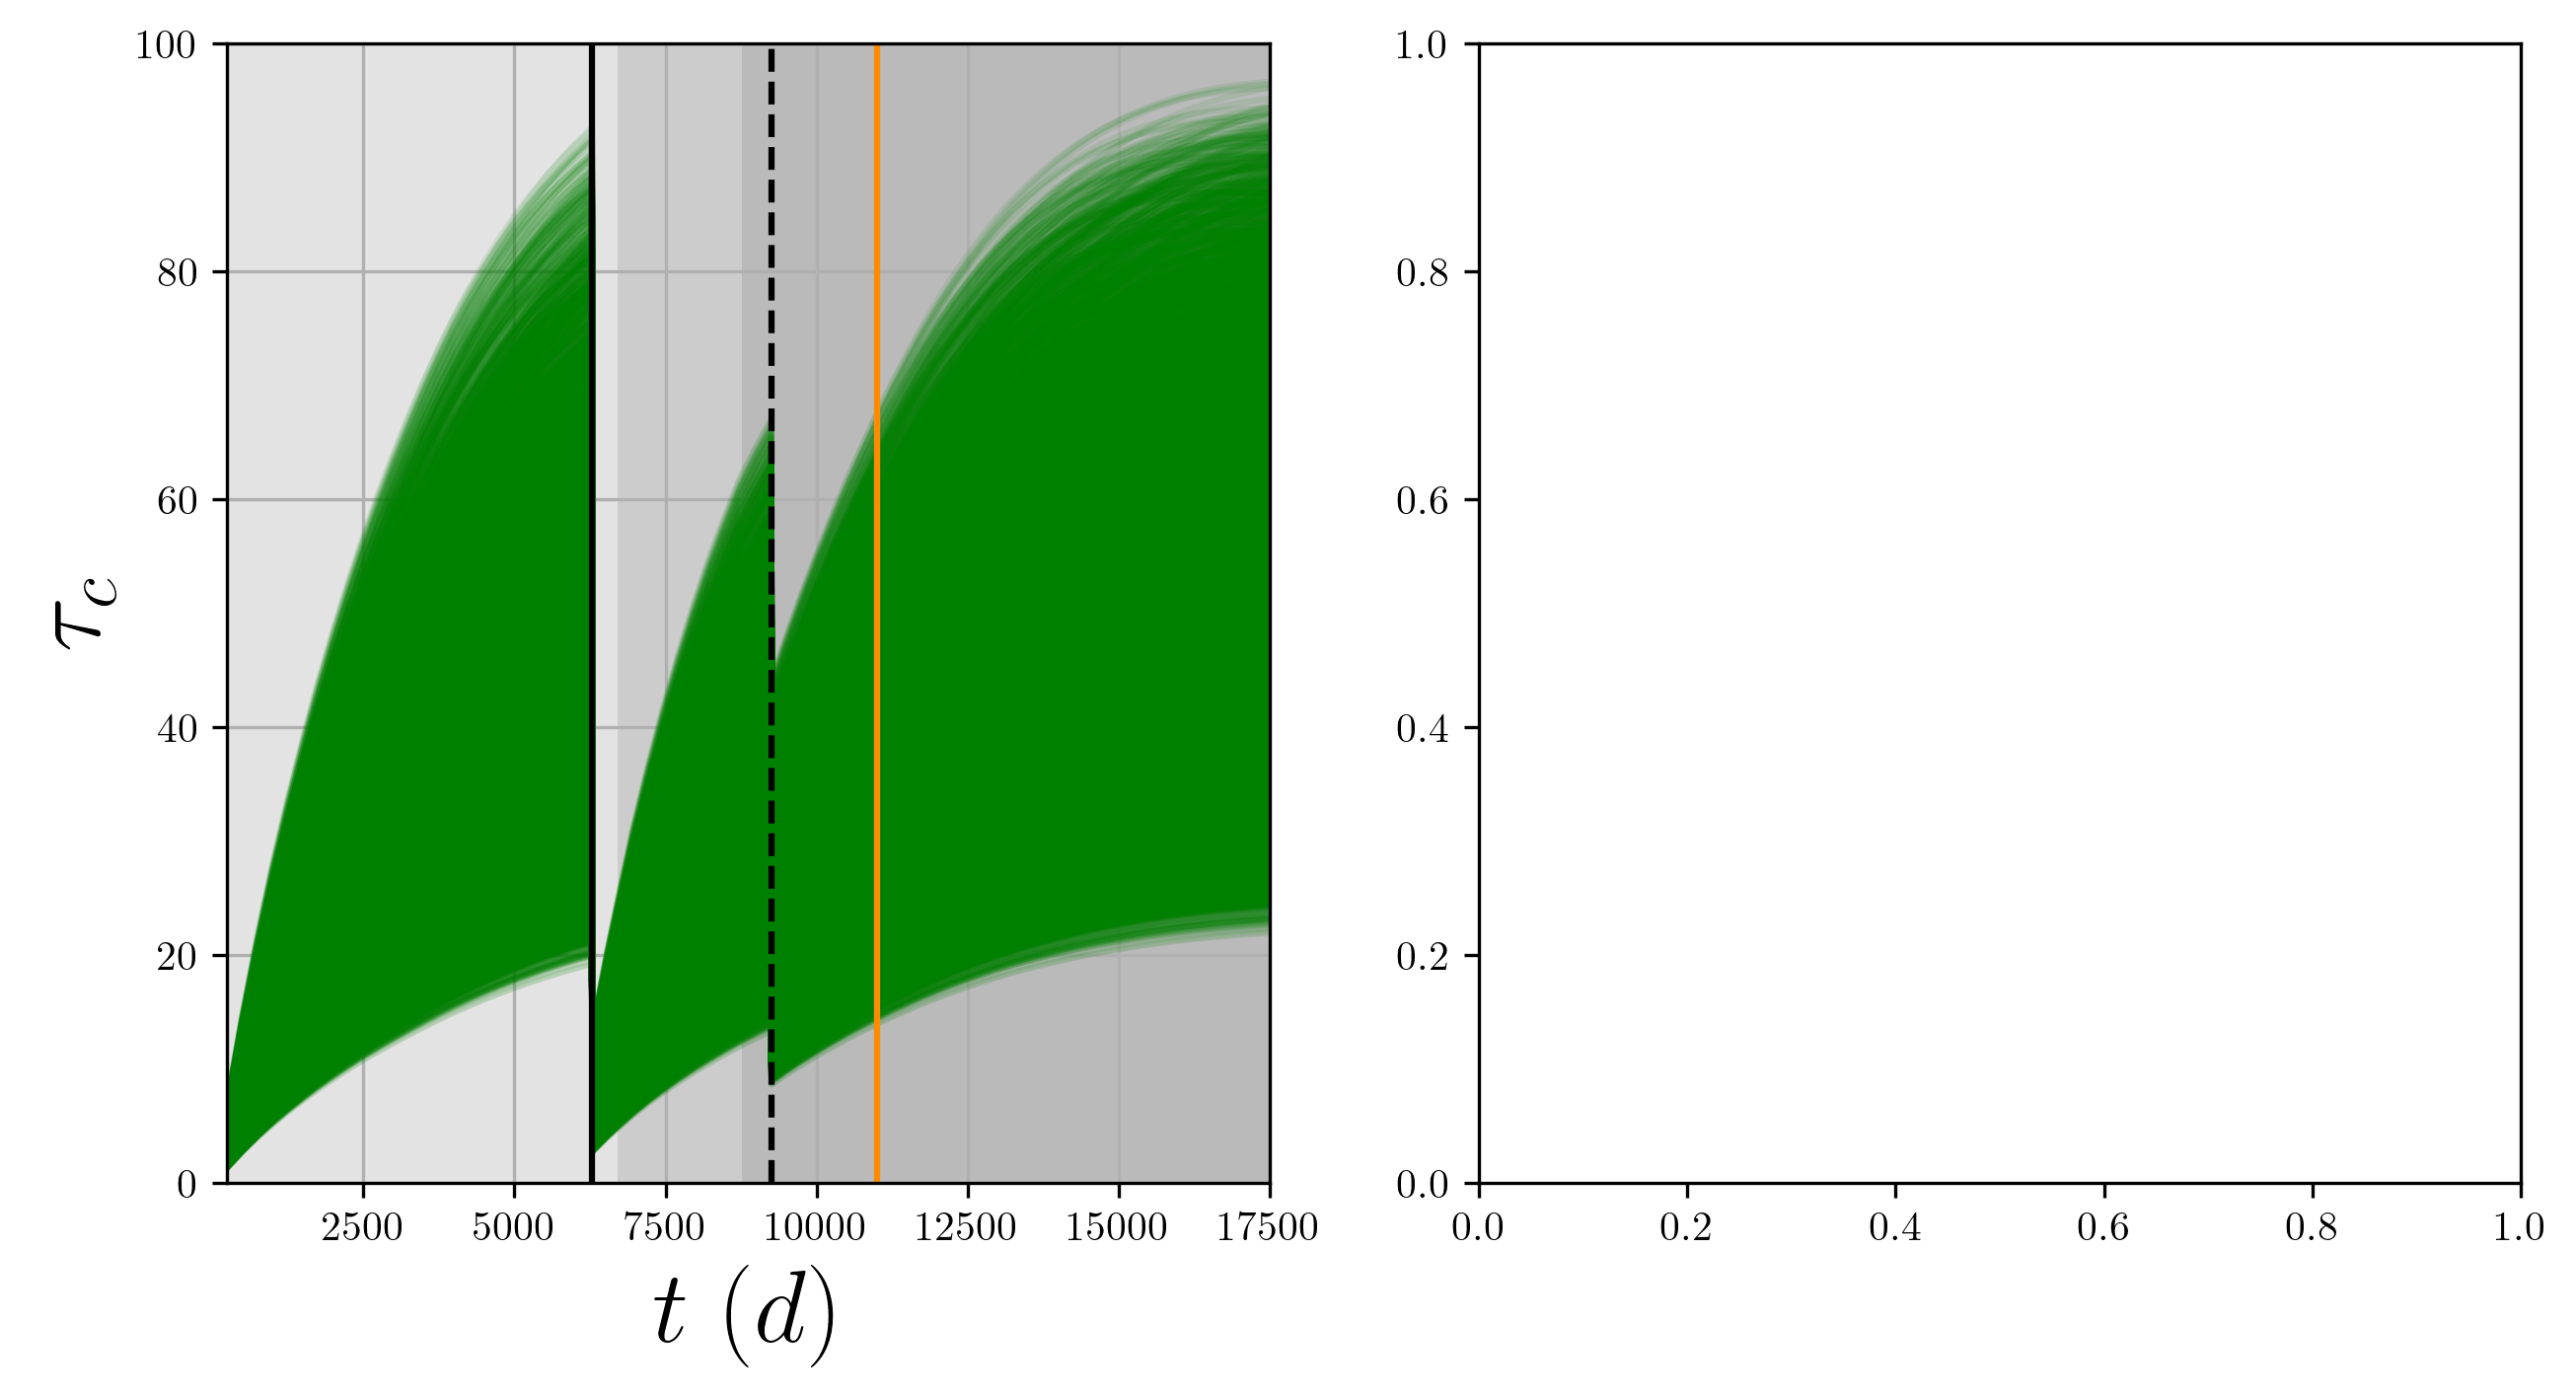

In [35]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0] = plot_tpd(axs[0], input_dic, traj_prior, SIMULATION_TIME, 'TPD')
axs[1] = plot_tpd(axs[1], input_dic, traj, SIMULATION_TIME, 'TPD')

for i in range(3):
    if i == 0:
        axs[0].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', label='Regression data', zorder=10)
        axs[0].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', label='Field data', zorder=10)
        axs[1].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', zorder=10)
        axs[1].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)
    else:
        axs[0].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red',  zorder=10)
        axs[0].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)
        axs[1].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', zorder=10)
        axs[1].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)

axs[0].grid(False)
axs[1].grid(False)

axs[0].set_yticks([])
axs[1].set_yticks([])

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.05,0.9), fontsize=20)

fig.suptitle(r'TPD simulations with prior distributions and after assimilation', fontsize=20)

In [39]:
posterior_distrib_dfs = []
for i in range(1):
    posterior_samples = np.asarray([np.asarray(posterior_distributions[i][j].getSample(1000)).reshape(-1) for j in range(len(posterior_distributions[i]))])
    #posterior_samples = posterior_samples / np.sum(posterior_samples, axis=0).reshape(-1,1)
    posterior_distrib_df = pd.DataFrame(posterior_samples.T, columns=['X'+str(j) for j in range(1,8)])
    posterior_distrib_dfs.append(posterior_distrib_df)

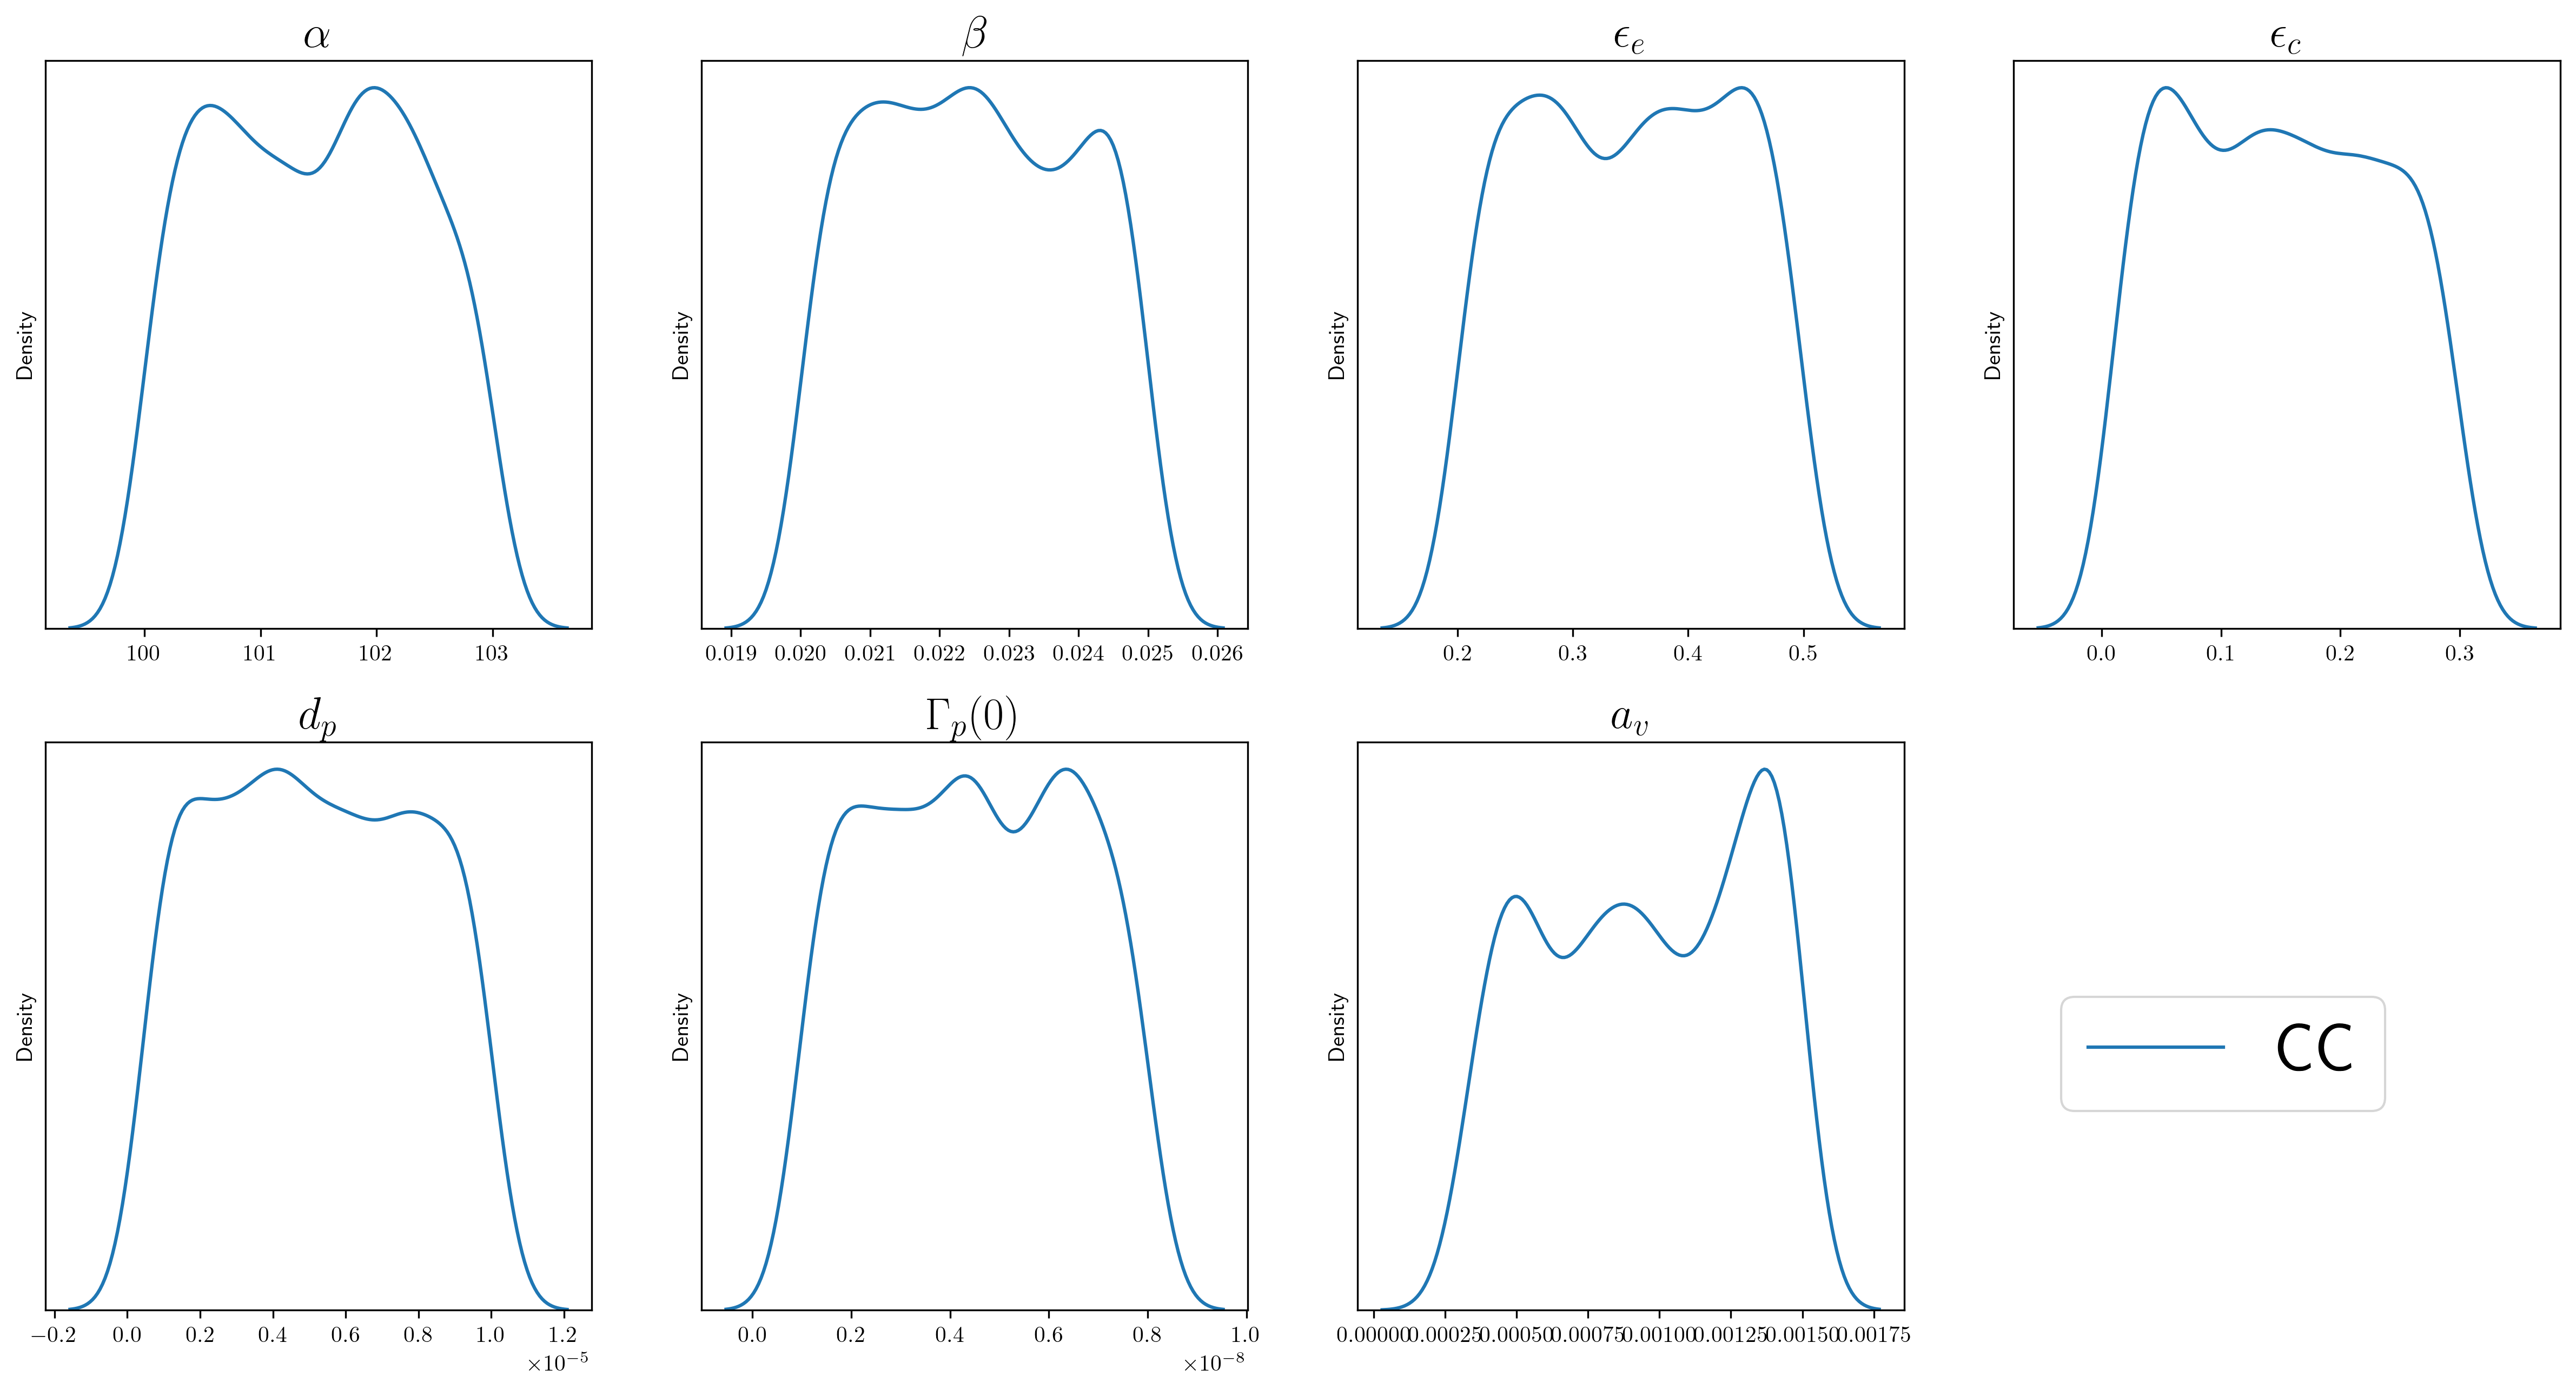

In [42]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
label = ['CC', 'CC-PC', 'PC']
titles = [r"$\alpha$", r"$\beta$", r"$\epsilon_e$", r"$\epsilon_c$", r"$d_p$", r"$\Gamma_{p}(0)$", r"$a_v$"]
for i in range(7):
    for j in range(1):
        if i == 6:
            sns.kdeplot(posterior_distrib_dfs[j]['X'+str(i+1)], ax=axs[i//4, i%4], label=label[j])
            axs[i//4, i%4].set_title(titles[i], fontsize=20)
            axs[i//4, i%4].set_xlabel('')
            axs[i//4, i%4].set_yticks([])
        else: 
            sns.kdeplot(posterior_distrib_dfs[j]['X'+str(i+1)], ax=axs[i//4, i%4])
            axs[i//4, i%4].set_title(titles[i], fontsize=20)
            axs[i//4, i%4].set_xlabel('')
            axs[i//4, i%4].set_yticks([])
fig.legend(loc=(0.8,0.2), fontsize=30)
fig.delaxes(axs[1, 3])